In [1]:
import numpy as np
import matplotlib.pyplot as plt

import fenics as fe

import sys
sys.path.insert(0, "../scripts")

from sfmcmc.nonlinear_poisson import NonlinearPoisson1D

In [2]:
nx = 64
pois = NonlinearPoisson1D(nx)
pois.setup_G(0.05)
I = np.eye(pois.n_dofs)

u = fe.TrialFunction(pois.V)
v = fe.TestFunction(pois.V)
A = fe.assemble(fe.inner(fe.grad(u), fe.grad(v)) * fe.dx)
pois.bc.apply(A)
A = A.array()

pois.u.vector()[:] = 1.
pois.u.vector()[pois.bc_dofs] = 0.

u = pois.u.vector()[:]
J = fe.assemble(pois.J).array()
T = J - A

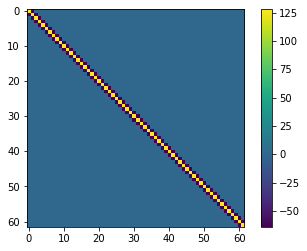

In [3]:
plt.imshow(A[1:-2, 1:-2])
plt.colorbar()
plt.show()

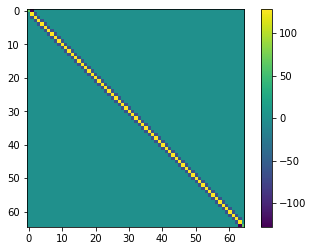

In [4]:
plt.imshow(T)
plt.colorbar()
plt.show()

Checking that our calculation is OK (modulo boundaries)

In [5]:
T.diagonal() - 2 * u**2 * nx

array([63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 63.])

In [6]:
vals, vecs = np.linalg.eig(A[1:-2, 1:-2])

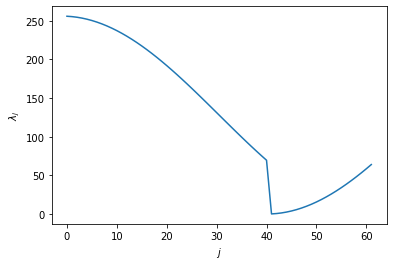

In [7]:
plt.plot(vals)
plt.xlabel("$j$")
plt.ylabel("$\lambda_j$")
plt.show()

In [8]:
print(vals.min())

0.15911408397788018


In [9]:
np.linalg.cond(A[1:-2, 1:-2])

1607.9084862876919

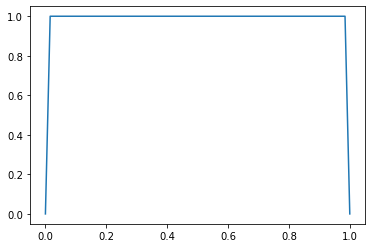

In [10]:
plt.plot(pois.x_dofs, u)
plt.show()

To compute the Hessian we need to the derivatve with respect to a 

0.0
0.0
0.0
0.0
0.0


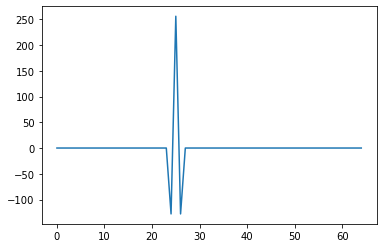

In [11]:
test_directions = [5, 10, 15, 20, 25]

for t in test_directions:
    d = fe.Function(pois.V)
    d.vector()[t] = 1.
    
    H = fe.assemble(fe.derivative(pois.J, pois.u, d))
    print(H.array()[t, t] - (4 * u[t] * nx))
    
plt.plot(H.array()[:, t])
plt.show()

Now we can run a basic gradient descent algorithm to see how things converge:

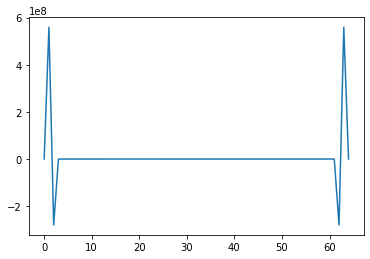

In [12]:
grad_map = pois.grad_phi(pois.u.vector()[:])
plt.plot(grad_map)
plt.show()

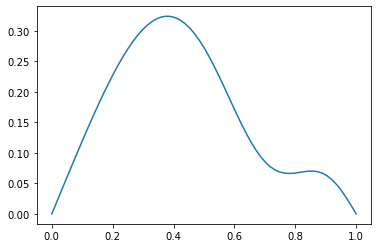

In [13]:
pois.setup_pc()
plt.plot(pois.x_dofs, pois.u.vector()[:])
plt.show()

## Now check the Hessian computation

In [103]:
H = pois.compute_hessian_map()

Calling FFC just-in-time (JIT) compiler, this may take some time.


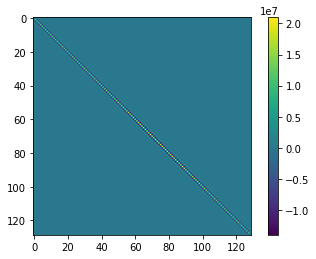

In [104]:
plt.imshow(H)
plt.colorbar()
plt.show()

In [105]:
pois.setup_pc()
M_sqrt_H = pois.M_inv_chol.solve_L(H.T, use_LDLt_decomposition=False)
H_pc = pois.M_inv_chol.solve_L(M_sqrt_H.T, use_LDLt_decomposition=False)

# compute the 'inner' condition number
print(f"{np.linalg.cond(H[1:-2, 1:-2]):.6e}")
print(f"{np.linalg.cond(H_pc[1:-2, 1:-2]):.6e}")

1.615967e+08
7.356728e+00


In [14]:
nx = 128
eta = 1e-8
n_sample = 100

pois = NonlinearPoisson1D(nx)
pois.setup_G(1.)
pois.setup_pc()

u_exact = pois.u.vector()[:]
u_samples = np.zeros((pois.n_dofs, n_sample))

pois.u_curr[:] = 0.

In [15]:
for i in range(n_sample):
    if pois.u_curr.max() >= 1e6:
        print(f"\nULA diverged at iteration {i} --- exiting")
        break
        
    if i % 100 == 0:
        print(f"\rIteration {i} of {n_sample}", end="")
    
    pois.ula_step(eta)
    u_samples[:, i] = pois.u_curr

Iteration 0 of 100

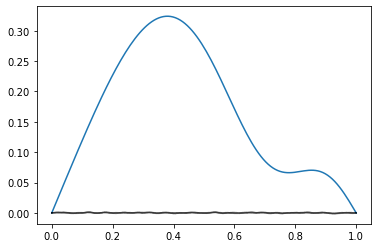

In [16]:
plt.plot(pois.x_dofs, u_exact)
plt.plot(pois.x_dofs, u_samples[:, -1000:], alpha=0.01, color="black")
plt.show()

In [17]:
n_sample = 2000

pula_samples = np.zeros((pois.n_dofs, n_sample))
pois.u_curr[:] = u_exact
eta_large = 0.01

for i in range(n_sample):
    if i % 100 == 0:
        print(f"\rIteration {i} of {n_sample}", end="")
        
    pois.pula_step(eta_large)
    pula_samples[:, i] = pois.u_curr

Iteration 1900 of 2000

In [18]:
exact_samples = np.zeros((pois.n_dofs, n_sample))

for i in range(n_sample):
    if i % 100 == 0:
        print(f"\rIteration {i} of {n_sample}", end="")
        
    exact_samples[:, i] = pois.exact_sample()

Iteration 1900 of 2000

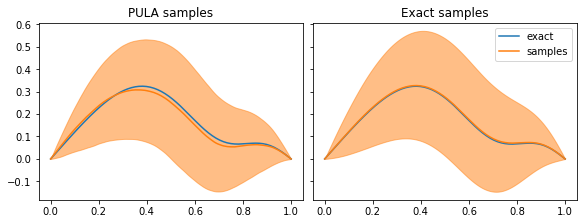

In [48]:
mean_pula = np.mean(pula_samples, axis=1)
var_pula = np.var(pula_samples, axis=1)
sd_pula = np.sqrt(var_pula)

mean_exact = np.mean(exact_samples, axis=1)
var_exact = np.var(exact_samples, axis=1)
sd_exact = np.sqrt(var_exact)

fig, axs = plt.subplots(1, 2, constrained_layout=True, sharey=True, figsize=(8, 3))
axs[0].plot(pois.x_dofs, u_exact, label="exact")
axs[0].plot(pois.x_dofs, mean_pula, label="pULA")
axs[0].fill_between(pois.x_dofs[:, 0],
                mean_pula + 1.96 * sd_pula,
                mean_pula - 1.96 * sd_pula,
                alpha=0.5,
                color="tab:orange")
axs[0].set_title("PULA samples")

axs[1].plot(pois.x_dofs, u_exact, label="exact")
axs[1].plot(pois.x_dofs, mean_exact, label="samples")
axs[1].fill_between(pois.x_dofs[:, 0],
                mean_exact + 1.96 * sd_exact,
                mean_exact - 1.96 * sd_exact,
                alpha=0.5,
                color="tab:orange")
axs[1].set_title("Exact samples")
axs[1].legend()
plt.show()

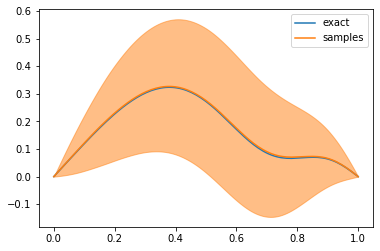

In [42]:
plt.plot(pois.x_dofs, u_exact, label="exact")
plt.plot(pois.x_dofs, mean_exact, label="samples")
plt.fill_between(pois.x_dofs[:, 0],
                mean_exact + 1.96 * sd_exact,
                mean_exact - 1.96 * sd_exact,
                alpha=0.5,
                color="tab:orange")
plt.legend()
plt.show()

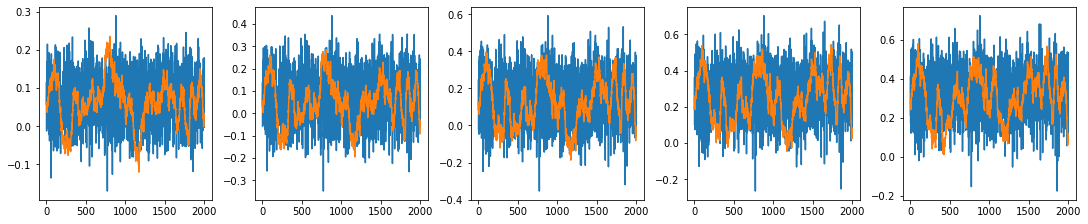

In [33]:
dofs = [16, 32, 48, 64, 80]
n_dofs = len(dofs)
fig, axs = plt.subplots(1, n_dofs, constrained_layout=True, figsize=(15, 3))
for i in range(n_dofs):
    axs[i].plot(exact_samples[dofs[i], :])
    axs[i].plot(pula_samples[dofs[i], :])

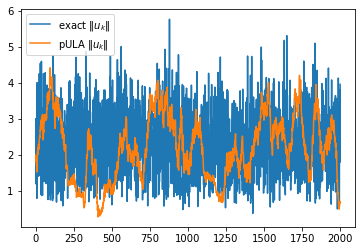

In [21]:
norm = np.linalg.norm
pula_norms = norm(exact_samples, axis=0)
exact_norms = norm(pula_samples, axis=0)

plt.plot(pula_norms, label=r"exact $\Vert u_k \Vert$")
plt.plot(exact_norms, label=r"pULA $\Vert u_k \Vert$")
plt.legend()
plt.show()

Now we do some classical MCMC plotting:

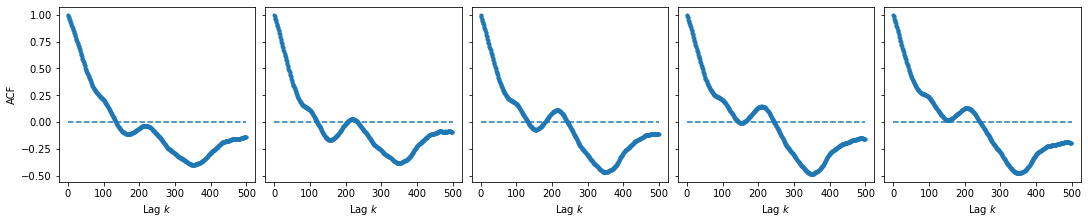

In [57]:
import arviz as az

fig, axs = plt.subplots(1, n_dofs, constrained_layout=True, figsize=(15, 3), sharey=True)

for i in range(n_dofs):
    pula_acf = az.autocorr(pula_samples[dofs[i], :])
    axs[i].plot(pula_acf[:500], ".-")
    axs[i].hlines(0., 0, 500, ls="--")
    axs[i].set_xlabel(r"Lag $k$")
    
axs[0].set_ylabel("ACF")    
plt.show()